# Pedro - Short Queeze Predictor
---

### 1. Libraries Import

In [75]:
import numpy as np
import pandas as pd
import yfinance as yf
from pathlib import Path
import pandas_market_calendars as mcal
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced
import hvplot.pandas
import matplotlib.pyplot as plt
from joblib import dump

### 2. Data Preparation Constants

In [49]:
SHORT_INTEREST_FLOAT_FILTER = 17
MARKET_CAP_FILTER = 300000000
TOTAL_AMOUNT_FILTER = 1000000
DESIRED_DAYS = [1, 2, 5, 7]
short_float_filepath = "Resources/ShortFloat.csv"
insider_trading_filepath = "Resources/InsiderTrading.csv"

### 3. Data Loading and Preprocessing Function

In [50]:
def load_and_preprocess_data(short_float_filepath, insider_trading_filepath):
    
    short_df = pd.read_csv(short_float_filepath)
    short_df.rename(columns={'ShortSqueeze.com Short Interest Data': 'Company Name'}, inplace=True)
    # Dropping irrelevant columns
    columns_to_drop = [
    'Total Short Interest', 'Days to Cover', 'Performance (52-wk)', 'Short: Prior Mo', '% Change Mo/Mo',
    'Shares: Float', 'Avg. Daily Vol.', 'Shares: Outstanding', 'Short Squeeze Ranking™', '% from 52-wk High',
    '(abs)', '% from 200 day MA', '(abs).1', '% from 50 day MA', '(abs).2', '% Insider Ownership',
    '% Institutional Ownership'
    ]
    columns_to_drop = [col for col in columns_to_drop if col in short_df.columns]
    short_df.drop(columns_to_drop, axis=1, inplace=True)
    # Convert 'Short % of Float' and 'Market Cap' to numeric and apply filters
    short_df['Short % of Float'] = pd.to_numeric(short_df['Short % of Float'], errors='coerce')
    short_df = short_df[short_df['Short % of Float'] >= SHORT_INTEREST_FLOAT_FILTER]
    short_df['Market Cap'] = pd.to_numeric(short_df['Market Cap'], errors='coerce')
    short_df = short_df[short_df['Market Cap'] >= MARKET_CAP_FILTER]
    
    insider_df = pd.read_csv(insider_trading_filepath)
    insider_df['Total Amount'] = insider_df['Total Amount'].replace({'\$': '', ',': ''}, regex=True).astype(float)
    insider_df['Share Price'] = insider_df['Share Price'].replace({'\$': '', ',': ''}, regex=True).astype(float)
    insider_df['Date'] = pd.to_datetime(insider_df['Date'])
    insider_df['Total Amount'] = pd.to_numeric(insider_df['Total Amount'], errors='coerce')
    insider_df = insider_df[insider_df['Total Amount'] >= TOTAL_AMOUNT_FILTER]
    
    return short_df, insider_df

In [51]:
# Load and preprocess data
short_df, insider_df = load_and_preprocess_data(short_float_filepath, insider_trading_filepath)

/var/folders/8b/qhtp32dn1ld9zhxxfhbnshq80000gn/T/ipykernel_70963/1168068969.py:3: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,24) have mixed types. Specify dtype option on import or set low_memory=False.
  short_df = pd.read_csv(short_float_filepath)


### 4. Feature Engineering Function

In [52]:
def feature_engineering(short_df, insider_df):
    date_mapping = {
    'JanA': '01-11', 'JanB': '01-25',
    'FebA': '02-09', 'FebB': '02-27',
    'MarA': '03-09', 'MarB': '03-24',
    'AprA': '04-12', 'AprB': '04-25',
    'MayA': '05-09', 'MayB': '05-24',
    'JunA': '06-09', 'JunB': '06-27',
    'JulA': '07-12', 'JulB': '07-25',
    'AugA': '08-09', 'AugB': '08-24',
    'SepA': '09-12', 'SepB': '09-26',
    'OctA': '10-10', 'OctB': '10-24',
    'NovA': '11-09', 'NovB': '11-27',
    'DecA': '12-11', 'DecB': '12-27',
    }
    
    short_df['Record Date'] = pd.to_datetime(short_df['Record Date'].str.replace(r'(\d{4})-(\w+)', lambda m: f'{m.group(1)}-{date_mapping[m.group(2)]}'))
    short_df.sort_values('Record Date', inplace=True)
    short_df.reset_index(drop=True, inplace=True)
    
    merged_df = pd.merge(short_df, insider_df, on='Symbol')
    merged_df['Share Price'] = merged_df['Share Price'].replace({'\$': '', ',': ''}, regex=True).astype(float)
    merged_df = merged_df[['Symbol', 'Short % of Float', 'Total Amount', 'Record Date', 'Share Price', 'Company Name', 'Sector', 'Industry', 'Date']]
    
    # Calculate the difference between 'Date' and 'Record Date' for each row
    merged_df['Date_diff'] = (merged_df['Date'] - merged_df['Record Date']).dt.days
    # Filter out rows where 'Date_diff' is more than 30 and drop unnecessary columns
    merged_df = merged_df[merged_df['Date_diff'] >= 0]
    merged_df.sort_values(['Symbol', 'Date_diff'], inplace=True)
    merged_df.drop_duplicates(subset=['Symbol', 'Date'], keep='first', inplace=True)
    merged_df = merged_df[merged_df['Date_diff'] <= 30]
    merged_df.drop(columns=['Record Date', 'Date_diff'], inplace=True)

    # Reorder columns
    new_column_order = ['Symbol', 'Short % of Float', 'Total Amount', 'Date', 'Company Name', 'Sector', 'Industry']
    merged_df = merged_df[new_column_order]
    
    # Create new columns for Close Prices at future dates and calculate Returns.
    nyse = mcal.get_calendar('NYSE')
    desired_days = DESIRED_DAYS
    for day in desired_days:
        merged_df[f'Close Price Day {day}'] = np.nan

    for idx, row in merged_df.iterrows():
        trading_days = nyse.valid_days(start_date=row['Date'], end_date=row['Date'] + pd.DateOffset(days=10))

        for day in desired_days:
            if day <= len(trading_days):
                data = yf.download(row['Symbol'], start=trading_days[day - 1], end=trading_days[day - 1] + pd.DateOffset(days=1))
                if not data.empty:  
                    merged_df.loc[idx, f'Close Price Day {day}'] = data['Close'][0] 
    
    # Calculate Returns and Highest Day Return
    for day in DESIRED_DAYS: 
        merged_df[f'Return ({day} Days)'] = ((merged_df[f'Close Price Day {day}'] - merged_df['Close Price Day 1']) / merged_df['Close Price Day 1']) * 100
        
    merged_df['Highest Day Return'] = merged_df[[f'Return ({day} Days)' for day in [5, 7]]].max(axis=1)
    merged_df['Highest Close Price'] = merged_df[[f'Close Price Day {day}' for day in desired_days]].max(axis=1)

    for col in merged_df.columns:
        if 'Close Price' in col or 'Return' in col:
            merged_df[col] = merged_df[col].round(2)

    merged_df.dropna(inplace=True)
    merged_df.reset_index(drop=True, inplace=True)
    
    merged_df['Short Squeeze'] = 0
    merged_df.loc[merged_df['Highest Day Return'] >= 20, 'Short Squeeze'] = 1
    merged_df.loc[merged_df['Highest Day Return'] < 20, 'Short Squeeze'] = 0

    return merged_df

In [ ]:
# Feature engineering
merged_df = feature_engineering(short_df, insider_df)

### Data Visualization

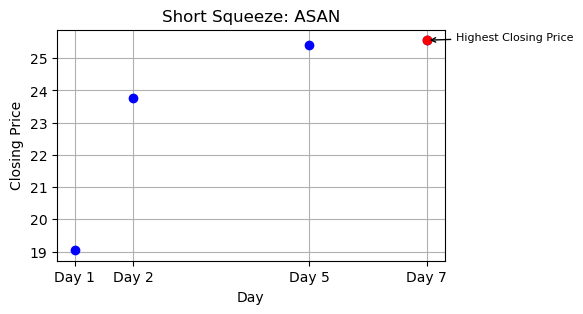

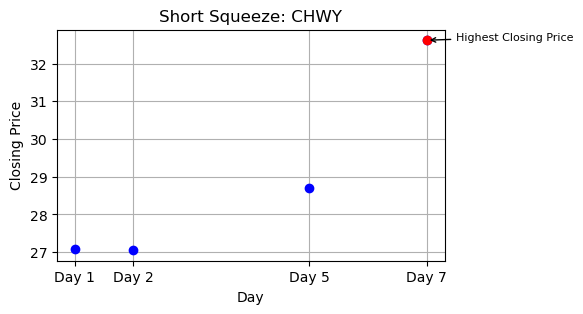

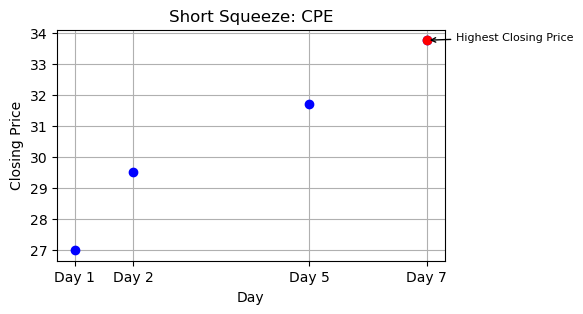

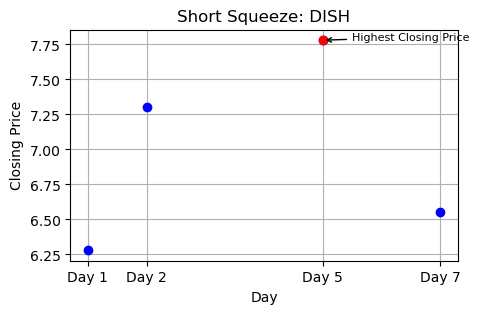

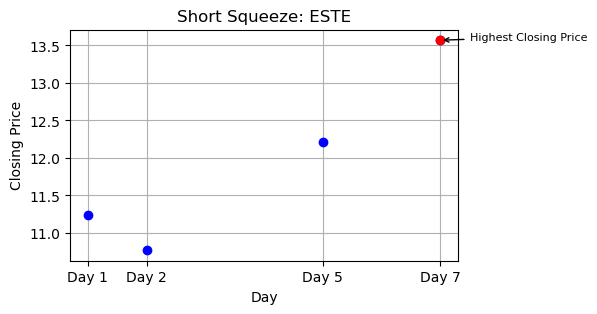

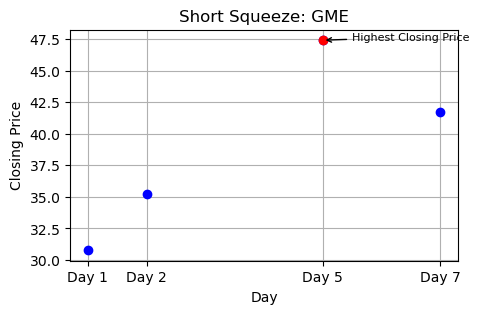

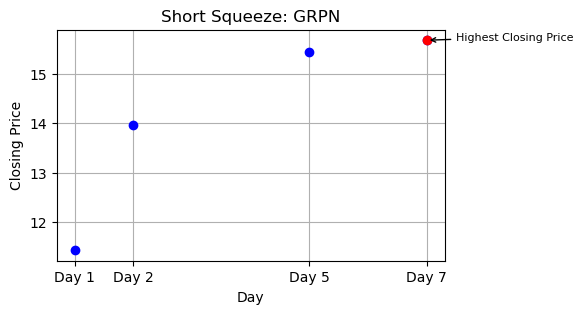

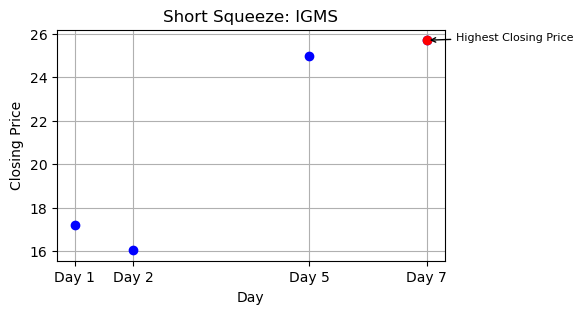

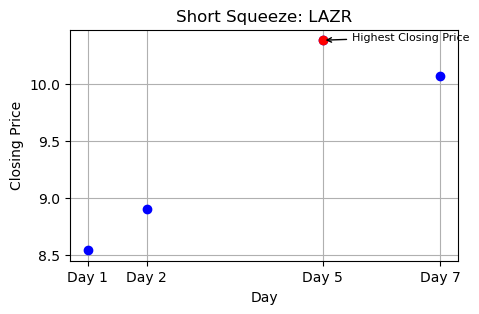

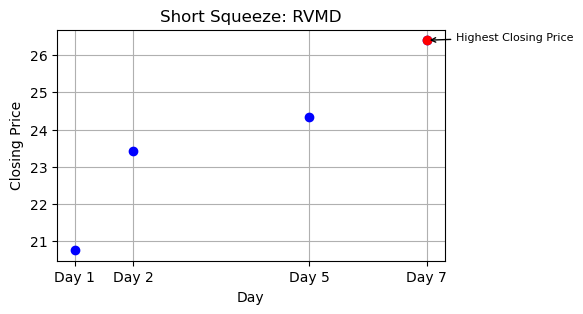

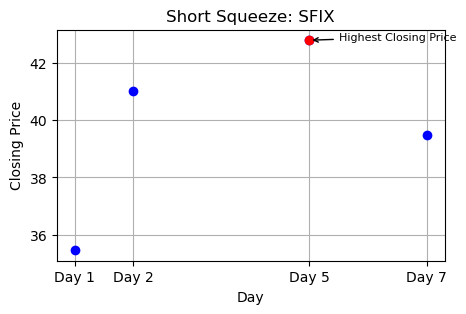

In [54]:
# Visualizing Short Squeeze
short_squeeze_df = merged_df[merged_df['Short Squeeze'] == 1]
grouped_df = short_squeeze_df.groupby('Symbol')
for symbol, data in grouped_df:
    # Sort the data by date
    data = data.sort_values('Date')
    plt.figure(figsize=(5, 3))
    days_to_plot = [1, 2, 5, 7]
    closing_prices = [data[f'Close Price Day {day}'].iloc[-1] for day in days_to_plot]
    plt.plot(days_to_plot, closing_prices, 'o', color='blue')
    highest_closing_price = max(closing_prices)
    highest_closing_price_day = days_to_plot[closing_prices.index(highest_closing_price)]
    plt.plot(highest_closing_price_day, highest_closing_price, 'ro')
    plt.annotate('Highest Closing Price',
                 xy=(highest_closing_price_day, highest_closing_price),
                 xytext=(highest_closing_price_day + 0.5, highest_closing_price),
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 fontsize=8,
                 ha='left')
    plt.xlabel('Day')
    plt.ylabel('Closing Price')
    plt.title(f'Short Squeeze: {symbol}')
    plt.xticks(days_to_plot, [f'Day {day}' for day in days_to_plot])
    plt.grid(True)
    plt.show()

In [55]:
# Looking at each short squeeze company 30 days before and after Insider Trading activity occurs
for symbol, data in grouped_df:
    start_date = pd.to_datetime(data['Date'].min()) - pd.DateOffset(days=30)
    end_date = pd.to_datetime(data['Date'].max()) + pd.DateOffset(days=30)
    yf_data = yf.download(symbol, start=start_date, end=end_date)
    close_prices = yf_data['Close']
    plot = close_prices.hvplot(title=f'{symbol} Short Squeeze', ylabel='Closing Price').opts(width=600, height=400)
    display(plot)

[*********************100%***********************]  1 of 1 completed


:Curve   [Date]   (Close)

[*********************100%***********************]  1 of 1 completed


:Curve   [Date]   (Close)

[*********************100%***********************]  1 of 1 completed


:Curve   [Date]   (Close)

[*********************100%***********************]  1 of 1 completed


:Curve   [Date]   (Close)

[*********************100%***********************]  1 of 1 completed


:Curve   [Date]   (Close)

[*********************100%***********************]  1 of 1 completed


:Curve   [Date]   (Close)

[*********************100%***********************]  1 of 1 completed


:Curve   [Date]   (Close)

[*********************100%***********************]  1 of 1 completed


:Curve   [Date]   (Close)

[*********************100%***********************]  1 of 1 completed


:Curve   [Date]   (Close)

[*********************100%***********************]  1 of 1 completed


:Curve   [Date]   (Close)

[*********************100%***********************]  1 of 1 completed


:Curve   [Date]   (Close)

### 5. One Hot Encoding

In [56]:
def one_hot_encode(df):
    encoder = OneHotEncoder(sparse=False)
    categorical_variables = ['Company Name', 'Sector', 'Industry']
    encoded_df = pd.DataFrame(encoder.fit_transform(df[categorical_variables]))
    encoded_df.columns = encoder.get_feature_names_out(categorical_variables)
    numerical_df = df.drop(columns=categorical_variables, axis=1)
    return pd.concat([numerical_df, encoded_df], axis=1)

In [57]:
# One hot encode the data
merged_df = one_hot_encode(merged_df)

/Users/kyle/opt/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### 6. Train-Test Split

In [58]:
X = merged_df.drop(columns=['Short Squeeze'])
y = merged_df['Short Squeeze']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 7. Data Normalization

In [59]:
# Drop the 'Symbol' column from X_train and X_test
X_train_scaled = X_train.drop('Symbol', axis=1)
X_test_scaled = X_test.drop('Symbol', axis=1)

# Drop the 'Date' column from X_train and X_test
X_train_scaled = X_train_scaled.drop('Date', axis=1)
X_test_scaled = X_test_scaled.drop('Date', axis=1)

# Scale the numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_scaled)
X_test_scaled = scaler.transform(X_test_scaled)

### 8. Model Training
#### Feedforward Neural Network (FNN)

In [60]:
model = Sequential()
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=2)

Epoch 1/50
3/3 - 0s - loss: 0.6614 - accuracy: 0.5753 - 336ms/epoch - 112ms/step
Epoch 2/50
3/3 - 0s - loss: 0.5763 - accuracy: 0.7671 - 5ms/epoch - 2ms/step
Epoch 3/50
3/3 - 0s - loss: 0.5128 - accuracy: 0.8493 - 4ms/epoch - 1ms/step
Epoch 4/50
3/3 - 0s - loss: 0.4622 - accuracy: 0.8493 - 4ms/epoch - 1ms/step
Epoch 5/50
3/3 - 0s - loss: 0.4184 - accuracy: 0.8493 - 3ms/epoch - 1ms/step
Epoch 6/50
3/3 - 0s - loss: 0.3818 - accuracy: 0.8493 - 5ms/epoch - 2ms/step
Epoch 7/50
3/3 - 0s - loss: 0.3511 - accuracy: 0.8767 - 4ms/epoch - 1ms/step
Epoch 8/50
3/3 - 0s - loss: 0.3235 - accuracy: 0.8904 - 4ms/epoch - 1ms/step
Epoch 9/50
3/3 - 0s - loss: 0.2987 - accuracy: 0.9178 - 4ms/epoch - 1ms/step
Epoch 10/50
3/3 - 0s - loss: 0.2770 - accuracy: 0.9178 - 5ms/epoch - 2ms/step
Epoch 11/50
3/3 - 0s - loss: 0.2557 - accuracy: 0.9315 - 4ms/epoch - 1ms/step
Epoch 12/50
3/3 - 0s - loss: 0.2370 - accuracy: 0.9452 - 4ms/epoch - 1ms/step
Epoch 13/50
3/3 - 0s - loss: 0.2193 - accuracy: 0.9452 - 4ms/epoch - 

### 9. Model Evaluation

In [61]:
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f'Test Accuracy: {accuracy*100:.2f}%')

Test Accuracy: 84.21%


### 10. Model Predictions

In [62]:
predictions = model.predict(X_test_scaled)
# Since this is a binary classification problem, we'll set a threshold at 0.5
predictions = [1 if pred > 0.5 else 0 for pred in predictions]

1/1 [==============================] - 0s 53ms/step


In [63]:
# You might want to compare these predictions with the actual values
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})

# Print out a sample of the comparison DataFrame
print(comparison_df.sample(10))

    Actual  Predicted
4        1          0
67       0          0
40       0          0
28       0          0
39       0          0
55       0          0
18       1          0
12       0          1
72       1          1
83       1          1


### 11. Performance Metrics

In [64]:
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90        15
           1       0.67      0.50      0.57         4

    accuracy                           0.84        19
   macro avg       0.77      0.72      0.74        19
weighted avg       0.83      0.84      0.83        19

[[14  1]
 [ 2  2]]


In [77]:
# Save the model
model.save('fnn_model')

# Load the model later
from tensorflow.keras.models import load_model
loaded_model = load_model('fnn_model')

INFO:tensorflow:Assets written to: fnn_model/assets


## Alternative Models
### Random Forest vs SMOTE

In [66]:
# Count the distinct values in the original labels data
y_train.value_counts()

0    61
1    12
Name: Short Squeeze, dtype: int64

In [67]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=1)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
rf_predictions = rf_model.predict(X_test_scaled)

In [70]:
# Instantiate SMOTE
smote_sampler = SMOTE(random_state=1, sampling_strategy='minority')

# Fit the SMOTE model to the training data
X_resampled, y_resampled = smote_sampler.fit_resample(X_train_scaled, y_train)

# Fit the RandomForestClassifier on the resampled data
model_resampled_rf = RandomForestClassifier()
model_resampled_rf.fit(X_resampled, y_resampled)

# Generate predictions based on the resampled data model
rf_resampled_predictions = model_resampled_rf.predict(X_test_scaled)

In [71]:
print(f'Original Data:\n{confusion_matrix(y_test, rf_predictions)}')
print(f'Oversampled Data:\n{confusion_matrix(y_test, rf_resampled_predictions)}')

Original Data:
[[15  0]
 [ 0  4]]
Oversampled Data:
[[15  0]
 [ 0  4]]


In [72]:
print(f'Original Data: {balanced_accuracy_score(y_test, rf_predictions)}')
print(f'Oversampled Data: {balanced_accuracy_score(y_test, rf_resampled_predictions)}')

Original Data: 1.0
Oversampled Data: 1.0


In [73]:
print(f'Original Data:\n{classification_report_imbalanced(y_test, rf_predictions)}')
print(f'Oversampled Data:\n{classification_report_imbalanced(y_test, rf_resampled_predictions)}')

Original Data:
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00        15
          1       1.00      1.00      1.00      1.00      1.00      1.00         4

avg / total       1.00      1.00      1.00      1.00      1.00      1.00        19

Oversampled Data:
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00        15
          1       1.00      1.00      1.00      1.00      1.00      1.00         4

avg / total       1.00      1.00      1.00      1.00      1.00      1.00        19



In [76]:
# Save the model
dump(rf_model, 'rf_model.joblib')
dump(model_resampled_rf, 'resampled_rf_model.joblib')

['resampled_rf_model.joblib']